In [1]:
import PIL as pil
from PIL import Image
import math

# Part I
#### Input: path to image1, desired number of rows and columns for 'tiles' of image 1
#### Output: list of [r, g, b] values corresponding to the *center pixel* in each tile

In [11]:
def img1_tileRGBs(path, num_cols, num_rows):

    pic1 = pil.Image.open(path).convert('RGB')
    width1, height1 = pic1.size
    
    px_per_col = math.ceil(width1/num_cols)
    px_per_row = math.ceil(height1/num_rows)
    
    ###This block could be consolidated, but leaving each step independent for future tinkering
    ###ie changing to average rgb per tile instead of center-value, etc.
    #find pixel-ranges of each col and row
    chunk_it_up_cols = [(x,x+px_per_col) for x in range(0, width1, px_per_col)]
    chunk_it_up_rows = [(y,y+px_per_row) for y in range(0, height1, px_per_row)]
    #adjust very last pixel_num since rows/cols probably didn't divide evenly
    chunk_it_up_cols[-1] = (chunk_it_up_cols[-1][0], width1-1)
    chunk_it_up_rows[-1] = (chunk_it_up_rows[-1][0], height1-1)
    #find center pixel in each col and row
    col_centers = [(i[0]+i[1])//2 for i in chunk_it_up_cols]
    row_centers = [(i[0]+i[1])//2 for i in chunk_it_up_rows]
    #knit into tuple, coordinate of px at the center of each tile
    center_px_coords = [(x,y) for x in col_centers for y in row_centers]
    #the order of center_px_coords is (col_0,row_0), (col_0,row_1), (col_0, row_2) ... on to col_1 once reach num_rows
    
    #rgb values for each center pixel
    return [list(pic1.getpixel(i)) for i in center_px_coords]

demo_pic1 [image source](https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/) (and some PIL basics)  

demo_pic2 [image source](https://edit.co.uk/blog/8-alternatives-generic-stock-photography-help-improve-bounce-rate/)

In [12]:
demo_pic1 = './opera.jpeg'
num_rows = 10 #random
num_cols = 15

p1_centerpx_rgbs = img1_tileRGBs(demo_pic1, num_cols, num_rows)

# Part II
#### Input: path to image 2
#### Output: exported image for each item in Part_I_output_list
* The colors of each export has been shifted so the _average overal R,G,B_ of the exported img matches the R,G,B of the Part_I_list_entry  
  
Code for total_avg 'adapted' (read: swiped) from [Sp3000's answer here](https://codegolf.stackexchange.com/questions/53621/force-an-average-on-an-image)

In [13]:
def total_avg(img_path):
    img = pil.Image.open(img_path).convert('RGB')
    width, height = img.size
    
    total_rgb = [0, 0, 0]
    
    for x in range(width):
        for y in range(height):
            for i in range(3): #rgb channels
                total_rgb[i] += img.getpixel((x,y))[i]
                
    return [int(i / (height*width)) for i in total_rgb]

In [14]:
demo_pic2 = './stock.png'

Ri, Gi, Bi = total_avg(demo_pic2)
print(Ri, Gi, Bi)

148 142 143


In [15]:
def all_the_exports(img_path, out_path, num_cols, num_rows, reference_rgbs):
    col = 1 #counters for export filenames
    row = 1
    
    for i in reference_rgbs:
        Rf, Gf, Bf = i
        Rmod, Gmod, Bmod = Rf-Ri, Gf-Gi, Bf-Bi
        
        #when you edit values in the pixel_map, it is changed the source image
        #thus must reload source image each iteration to reset the modified pixels
        pic2 = pil.Image.open(img_path).convert('RGB')
        p2_pixelmap = pic2.load()
        width2, height2 = pic2.size
        
        for x in range(width2):
            for y in range(height2):
                p2_pixelmap[x,y] = (p2_pixelmap[x,y][0]+Rmod, p2_pixelmap[x,y][1]+Gmod, p2_pixelmap[x,y][2]+Bmod)
                #this syntax defacto restricted to 0-255. No risk of negatives or >255
                
        pic2.save(f'{out_path}/col{col}row{row}.png')
        row += 1
        if (row-1) % num_rows == 0:
            row = 1
            col += 1

In [17]:
out_path = './scratch/prac_images/test_export1'

all_the_exports(demo_pic2, out_path, num_cols, num_rows, p1_centerpx_rgbs)

## Check it oot

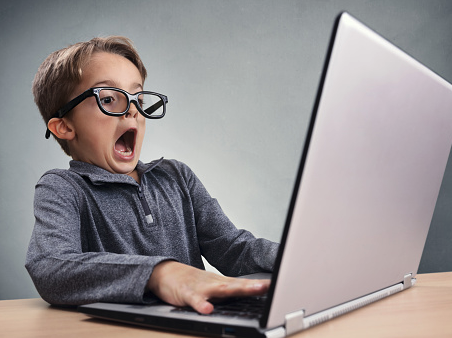

In [19]:
#original img2
pic2 = pil.Image.open('./stock.png').convert('RGB')
pic2

In [25]:
#open in desktop viewer
# import os
# for i in os.listdir('./example_outputs/'):
#     mod_img = pil.Image.open(f'./example_outputs/{i}')
#     mod_img.show()

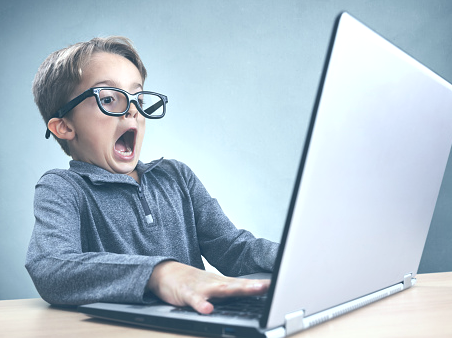

In [27]:
example_1 = pil.Image.open('./example_outputs/col1row1.png')
example_1

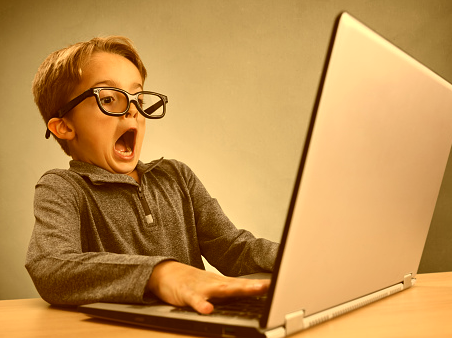

In [28]:
example_2 = pil.Image.open('./example_outputs/col2row6.png')
example_2

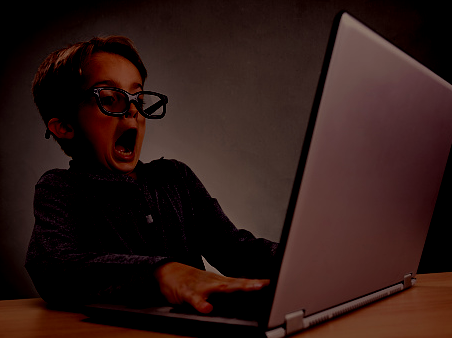

In [29]:
example_3 = pil.Image.open('./example_outputs/col3row7.png')
example_3

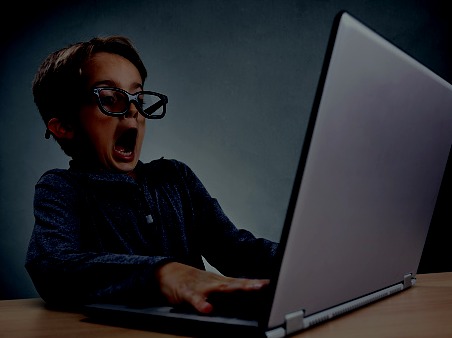

In [30]:
example_4 = pil.Image.open('./example_outputs/col15row6.png')
example_4